In [3]:
# 📦 Import librerie
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

# 📥 Caricamento dataset
file_path = "../data/prodromi_ctgan_balanced_clean.csv"
df = pd.read_csv(file_path)

# 🎯 Focus sulla classe 1011 (Hyposmia + REM + Depression)
target_col = "prodromi_combo"
df = df[df[target_col].isin(["1011",  # target
                            "0000", "0001", "0010", "0011", "0100", "0101",
                            "0110", "0111", "1000", "1001", "1010", "1100", "1101", "1110", "1111"])]

# 👨‍⚕️ Conversione target in binario: 1 se 1011, 0 altrimenti
df["target_1011"] = (df[target_col] == "1011").astype(int)

# 🔢 Selezione feature numeriche
X = df.select_dtypes(include=np.number).drop(columns=["target_1011"])
y = df["target_1011"]

# 🧼 Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✂️ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# 🔍 GridSearchCV setup
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(estimator=rf, param_grid=param_grid,
                  scoring='f1', cv=5, verbose=1, n_jobs=-1)

# 🚀 Training
print("🔁 Training Random Forest con GridSearchCV...")
gs.fit(X_train, y_train)

# ✅ Valutazione
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

print("\n📋 Best Parameters:")
print(gs.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print(f"\n🎯 F1-Score finale per classe 1011 (vs tutte): {f1:.4f}")

ValueError: Found array with 0 sample(s) (shape=(0, 31)) while a minimum of 1 is required by StandardScaler.

In [4]:
print(df.shape)
print(df.columns)
print(df.head())
print(df['prodromi_combo'].value_counts(dropna=False))

(0, 32)
Index(['HR V', 'HR ML', 'HR AP', '%det V', '%det ML', '%det AP',
       'Sex (M=1, F=2)', 'Age', 'Heigth', 'Weigth', 'Duration (years)',
       'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
       'Postural Alteration\n(1=si,2=no)',
       'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
       'Falls last year (1=si, 2=no)', 'H-Y', 'Tilt', 'Obliquity', 'Rotation',
       'Stance', 'Swing', 'Double Support', 'Single Support', 'Stride Length',
       'Cadence', 'Gait Speed', 'Constipation', 'Hyposmia', 'REM',
       'Depression', 'prodromi_combo', 'target_1011'],
      dtype='object')
Empty DataFrame
Columns: [HR V, HR ML, HR AP, %det V, %det ML, %det AP, Sex (M=1, F=2), Age, Heigth, Weigth, Duration (years), Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) ), Postural Alteration
(1=si,2=no), Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4, Falls last year (1=si, 2=no), H-Y, Tilt, Obliquity, Ro

In [7]:
import pandas as pd

# Carica file completo NON filtrato
df = pd.read_csv("../data/prodromi_ctgan_final.csv")

# Controlla valori presenti
print("Valori disponibili in prodromi_combo:")
print(df["prodromi_combo"].value_counts())

# Filtra la classe 1011
df_1011 = df[df["prodromi_combo"] == 1011]
print("Forma del nuovo dataframe:", df_1011.shape)


Valori disponibili in prodromi_combo:
prodromi_combo
11      46
1110    40
1001    40
111     40
100     40
1100    40
1111    40
101     40
10      40
0       40
1011    40
1101    40
110     40
Name: count, dtype: int64
Forma del nuovo dataframe: (40, 13)


In [9]:
# 📦 Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 📥 Carica dati filtrati
df = pd.read_csv("../data/prodromi_ctgan_final.csv")

# 🎯 Crea target binario
df["target_1011"] = (df["prodromi_combo"] == 1011).astype(int)

# ✅ Seleziona solo le feature scelte e il target
selected_features = ['%det ML', '%det AP',
                     'Sex (M=1, F=2)', 'Age', 'Duration (years)',
                     'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
                     'Postural Alteration\n(1=si,2=no)',
                     'Tilt','Double Support', 'Single Support', 'Stride Length',
                     'Cadence']

X = df[selected_features]
y = df["target_1011"]

# 🧼 Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✂️ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 🔍 Hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ✅ Miglior modello
best_model = grid_search.best_estimator_
print("Migliori iperparametri:", grid_search.best_params_)

# 📊 Valutazione
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Migliori iperparametri: {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0      0.951     1.000     0.975        98
           1      1.000     0.375     0.545         8

    accuracy                          0.953       106
   macro avg      0.976     0.688     0.760       106
weighted avg      0.955     0.953     0.943       106



In [17]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Crea i DataFrame
X_train_df = pd.DataFrame(X_train, columns=selected_features)
X_test_df = pd.DataFrame(X_test, columns=selected_features)

# ✅ Wrapper del modello per renderlo callable
def model_predict(X):
    return best_model.predict_proba(X)

# ✅ Crea masker
masker = shap.maskers.Independent(X_train_df)

# ✅ Inizializza explainer (Permutation)
explainer = shap.Explainer(model_predict, masker=masker, algorithm="permutation")

# ✅ Calcolo SHAP
shap_values = explainer(X_test_df)

# ✅ Controlla forme
print("SHAP values shape:", shap_values.values.shape)
print("X_test_df shape:", X_test_df.shape)

# ✅ Plot beeswarm
shap.plots.beeswarm(shap_values, max_display=15)

# ✅ Plot bar
shap.plots.bar(shap_values, max_display=15)

/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/

SHAP values shape: (106, 12, 2)
X_test_df shape: (106, 12)


ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dantetrabassi/Desktop/Prodromal_Parkinson/.venv/lib/python3.11/site-packages/

SHAP values shape: (106, 12, 2)
X_test_df shape: (106, 12)


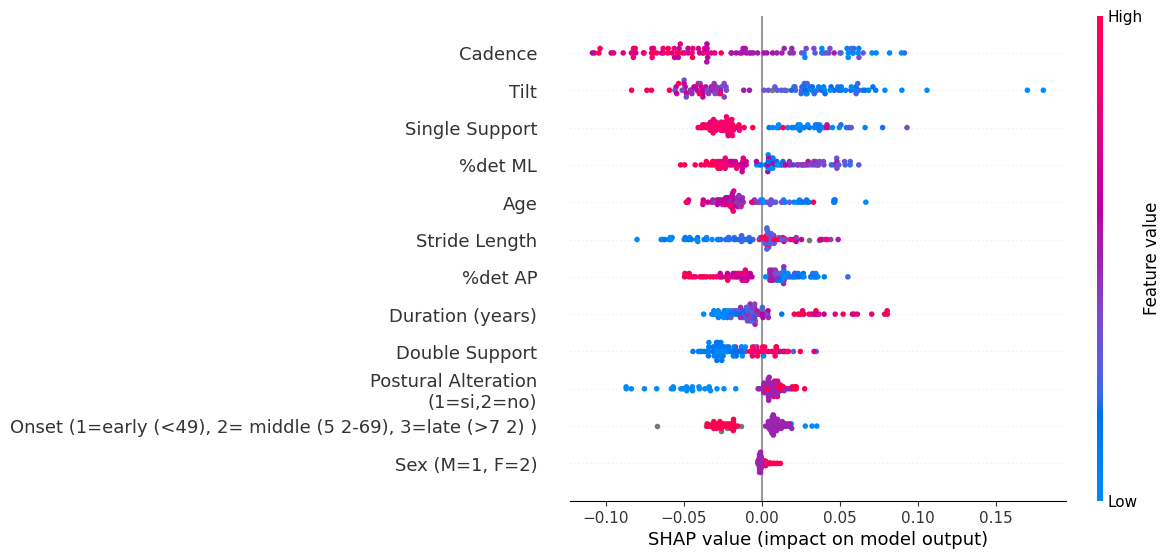

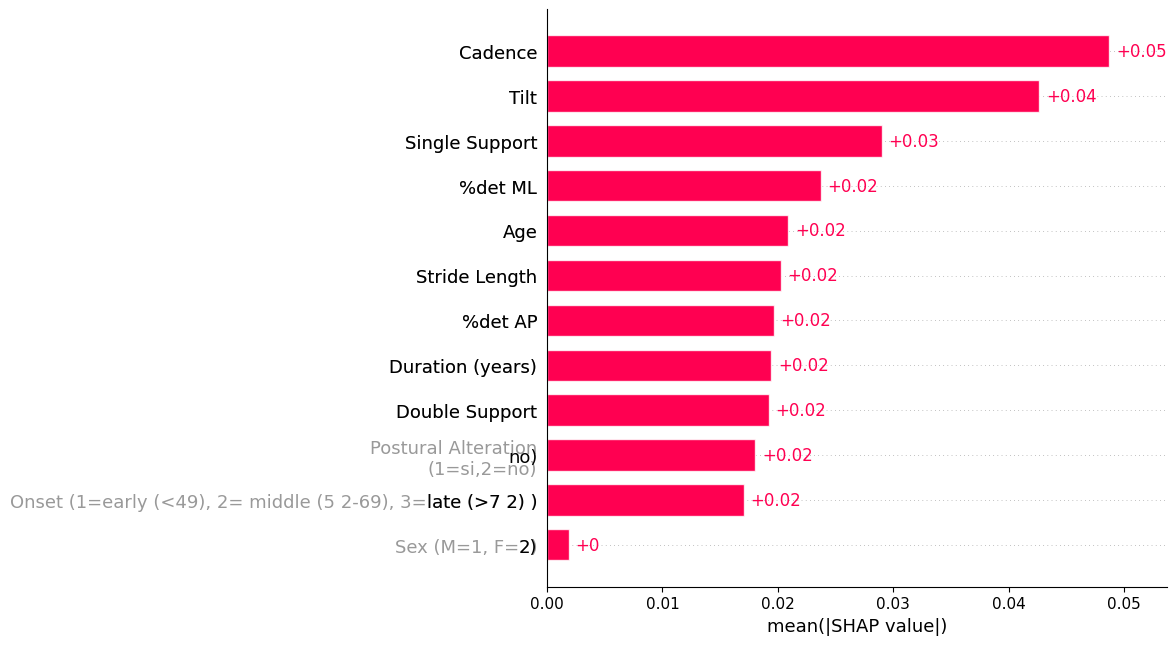

In [19]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Crea i DataFrame
X_train_df = pd.DataFrame(X_train, columns=selected_features)
X_test_df = pd.DataFrame(X_test, columns=selected_features)

# ✅ Wrapper del modello per renderlo callable
def model_predict(X):
    return best_model.predict_proba(X)

# ✅ Crea masker
masker = shap.maskers.Independent(X_train_df)

# ✅ Inizializza explainer (Permutation)
explainer = shap.Explainer(model_predict, masker=masker, algorithm="permutation")

# ✅ Calcolo SHAP
shap_values = explainer(X_test_df)

# ✅ Controlla forme
print("SHAP values shape:", shap_values.values.shape)  # Es. (106, 12, 2)
print("X_test_df shape:", X_test_df.shape)

# ✅ Seleziona solo SHAP values per la classe 1 (presenza combinazione 1011)
shap_values_class1 = shap.Explanation(
    values=shap_values.values[..., 1],
    base_values=shap_values.base_values[:, 1],
    data=X_test_df.values,
    feature_names=selected_features
)

# ✅ Beeswarm Plot per la classe 1
shap.plots.beeswarm(shap_values_class1, max_display=15)

# ✅ Bar Plot per la classe 1
shap.plots.bar(shap_values_class1, max_display=15)

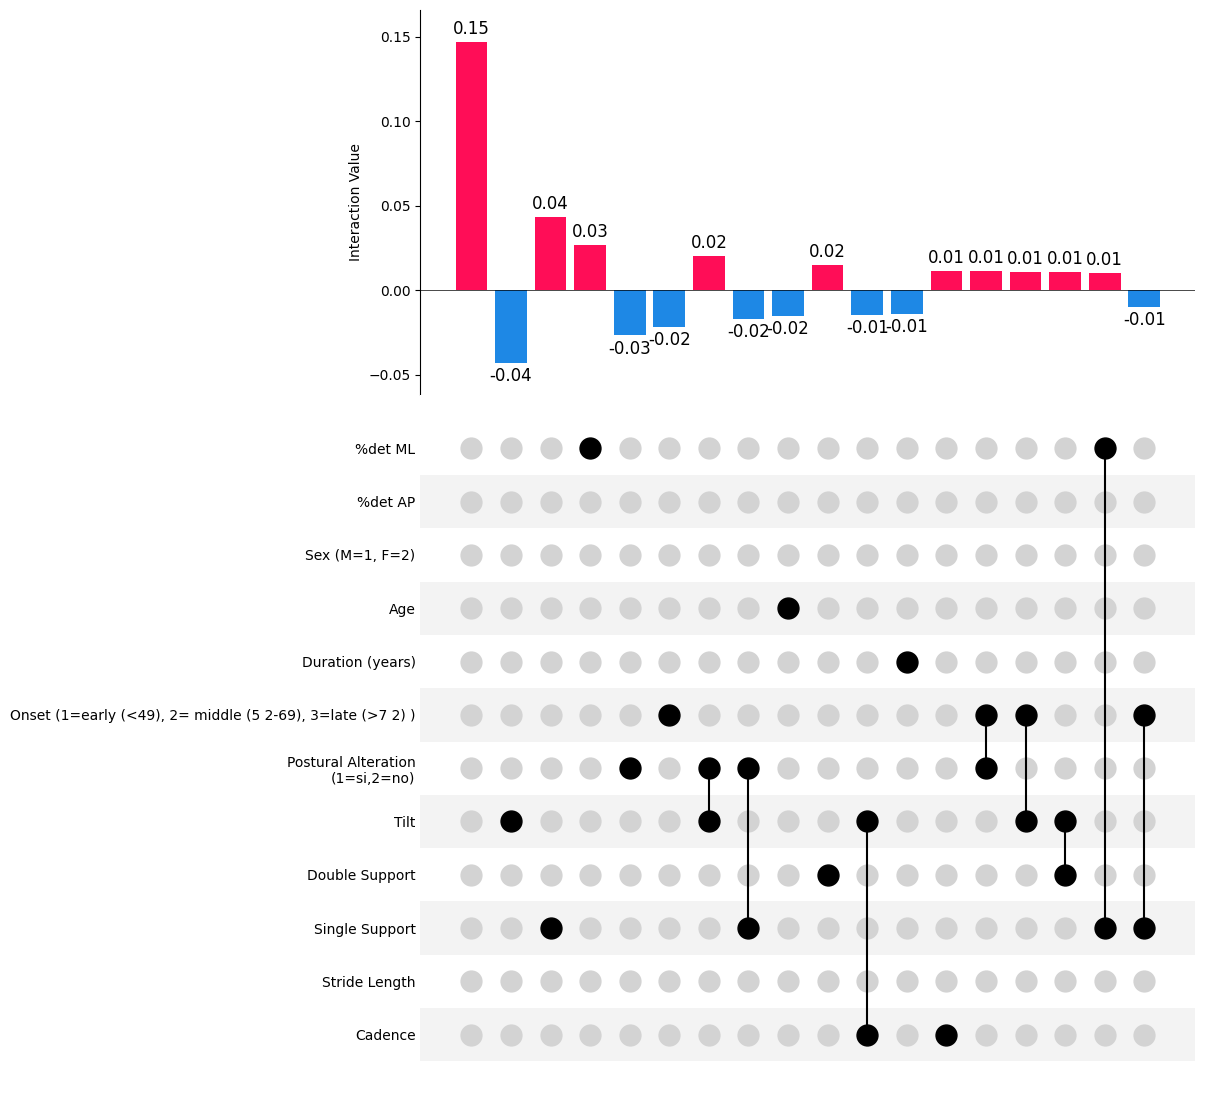

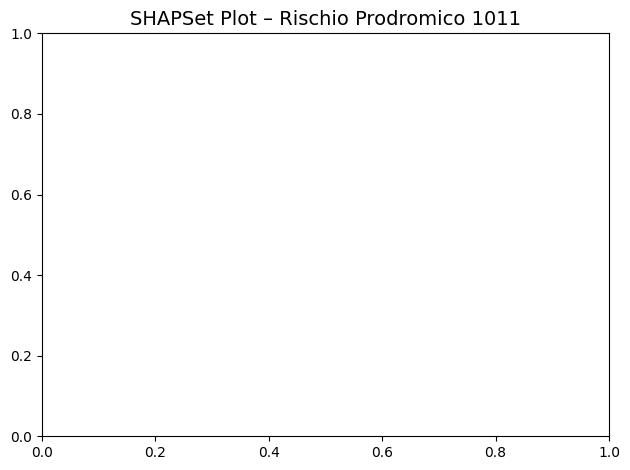

In [53]:
# 📦 Import
import shapiq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 📥 Carica dataset
df = pd.read_csv("../data/prodromi_ctgan_final.csv")
df["target_1011"] = (df["prodromi_combo"] == 1011).astype(int)

# ✅ Seleziona le feature
selected_features = ['%det ML', '%det AP',
                     'Sex (M=1, F=2)', 'Age', 'Duration (years)',
                     'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
                     'Postural Alteration\n(1=si,2=no)',
                     'Tilt', 'Double Support', 'Single Support',
                     'Stride Length', 'Cadence']

X = df[selected_features]
y = df["target_1011"]

# ⚙️ Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# 📥 Carica il modello Random Forest
model = joblib.load("../models/rf_model_1011.pkl")

# ⚠️ Wrapper per ottenere solo la probabilità della classe 1
def predict_proba_class1(X):
    return model.predict_proba(X)[:, 1]

# 🧠 Inizializza spiegatore SHAP-IQ
explainer = shapiq.TabularExplainer(
    model=predict_proba_class1,
    data=X_test,
    index="FSII",         # metodo di stima
    max_order=2,          # fino a interazioni a coppie
    random_state=42
)

# 🎯 Soggetto da spiegare
x_explain = X_test[25]

# 🔍 Calcola spiegazione
explanation = explainer.explain(x_explain, budget=300)

# 📊 SHAPSet Plot (Upset Plot) con nomi reali delle feature
fig = explanation.plot_upset(feature_names=selected_features, n_interactions=18)
plt.title("SHAPSet Plot – Rischio Prodromico 1011", fontsize=14)
plt.tight_layout()
plt.show()

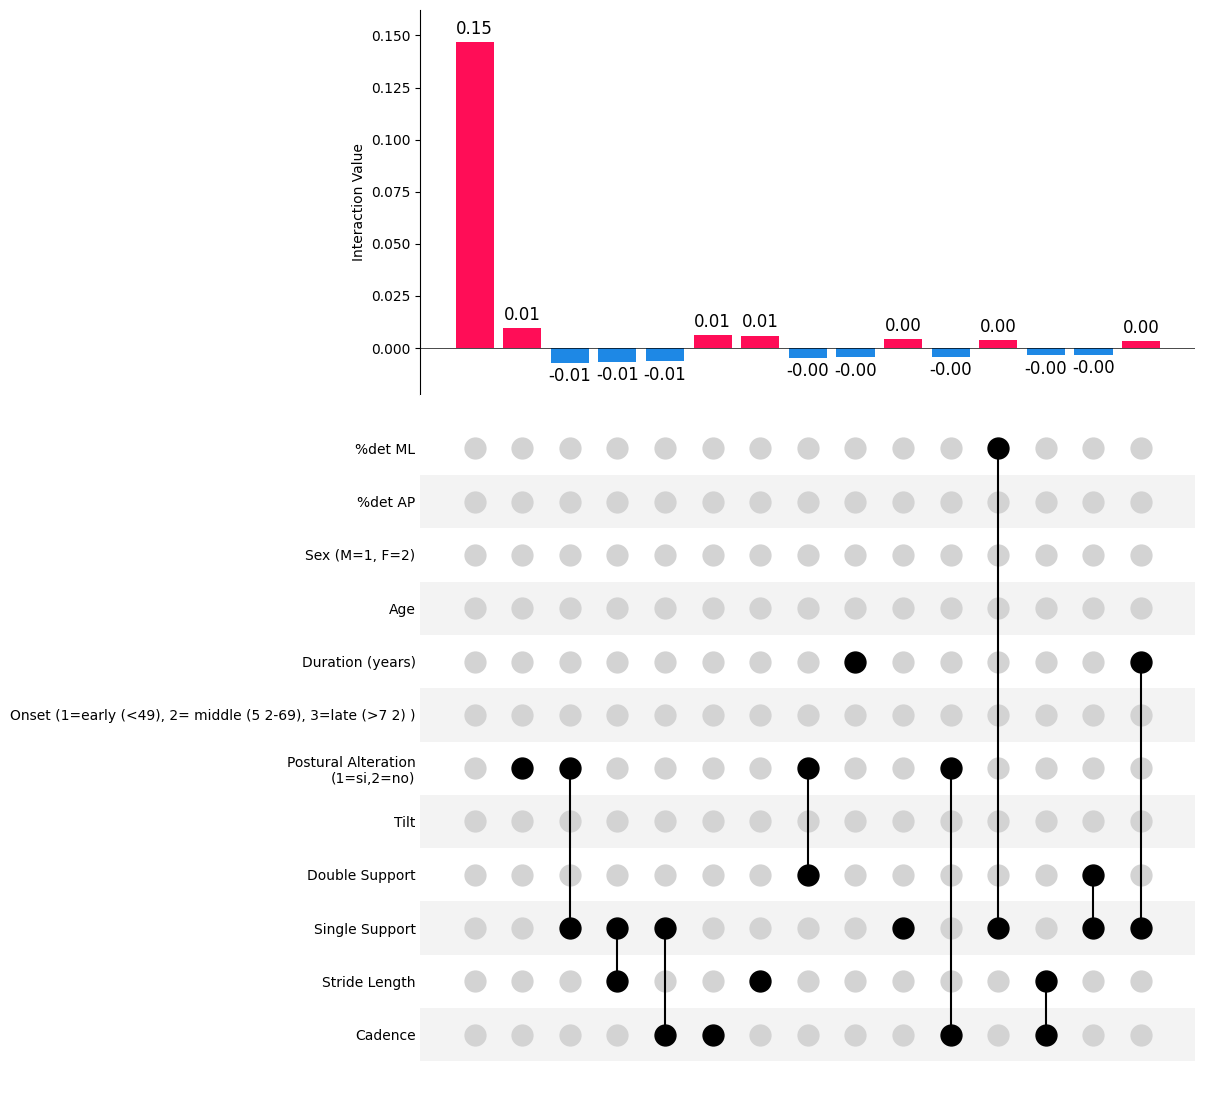

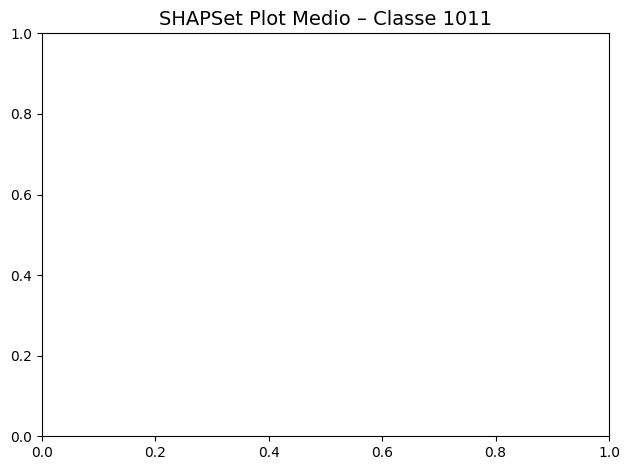

In [49]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from shapiq.interaction_values import InteractionValues

# Parametri
n_subjects = 106  # Numero di soggetti da analizzare
budget = 200
interaction_dict = defaultdict(list)

# Loop su soggetti nel test set
for i in range(n_subjects):
    x_i = X_test[i]
    explanation_i = explainer.explain(x_i, budget=budget)
    
    for subset, value in explanation_i.dict_values.items():
        interaction_dict[tuple(sorted(subset))].append(value)

# Calcola la media per ciascuna interazione
mean_interactions = {k: np.mean(v) for k, v in interaction_dict.items()}

# Ordina per contributo assoluto
top_k = 15
sorted_interactions = sorted(mean_interactions.items(), key=lambda x: abs(x[1]), reverse=True)[:top_k]

# Costruisci oggetto aggregato
interaction_lookup = {tuple(k): idx for idx, (k, _) in enumerate(sorted_interactions)}

# 🧠 Costruzione oggetto InteractionValues medio (come già fatto prima)
agg_explanation = InteractionValues(
    values=np.array([v for _, v in sorted_interactions]),
    index="FSII",
    max_order=2,
    n_players=len(selected_features),
    min_order=1,
    baseline_value=0.0,
    interaction_lookup={tuple(k): i for i, (k, _) in enumerate(sorted_interactions)}
)

# 📊 SHAPSet Plot medio con nomi delle feature
agg_explanation.plot_upset(
    n_interactions=len(sorted_interactions),
    feature_names=selected_features,  # ✅ nomi veri qui
    show=True
)

plt.title("SHAPSet Plot Medio – Classe 1011", fontsize=14)
plt.tight_layout()
plt.show()

AttributeError: 'InteractionValues' object has no attribute 'subsets'

In [10]:
import joblib
import os

# 📁 Crea directory se non esiste
os.makedirs("../models", exist_ok=True)

# 💾 Salva modello Random Forest
joblib.dump(best_model, "../models/rf_model_1011.pkl")

# 💾 Salva scaler
joblib.dump(scaler, "../models/scaler_1011.pkl")

print("✅ Modello e scaler salvati correttamente.")

✅ Modello e scaler salvati correttamente.
